## Data loading and pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('mode.chained_assignment', None)

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.optimizers import RMSprop
from keras.callbacks import Callback

In [2]:
humidity = pd.read_csv("/content/humidity.csv")
temp = pd.read_csv("/content/temperature.csv")
pressure = pd.read_csv("/content/pressure.csv")

In [3]:
humidity_SF = humidity[['datetime','San Francisco']]
temp_SF = temp[['datetime','San Francisco']]
pressure_SF = pressure[['datetime','San Francisco']]

In [4]:
humidity_SF.head(10)

,datetime,San Francisco
0,2012-10-01 12:00:00,NaN
1,2012-10-01 13:00:00,88.0
2,2012-10-01 14:00:00,87.0
3,2012-10-01 15:00:00,86.0
4,2012-10-01 16:00:00,85.0
5,2012-10-01 17:00:00,84.0
6,2012-10-01 18:00:00,83.0
7,2012-10-01 19:00:00,82.0
8,2012-10-01 20:00:00,81.0
9,2012-10-01 21:00:00,80.0


In [5]:
humidity_SF.tail(10)

,datetime,San Francisco
45243,2017-11-29 15:00:00,NaN
45244,2017-11-29 16:00:00,NaN
45245,2017-11-29 17:00:00,NaN
45246,2017-11-29 18:00:00,NaN
45247,2017-11-29 19:00:00,NaN
45248,2017-11-29 20:00:00,NaN
45249,2017-11-29 21:00:00,NaN
45250,2017-11-29 22:00:00,NaN
45251,2017-11-29 23:00:00,NaN
45252,2017-11-30 00:00:00,NaN


In [6]:
print(humidity_SF.shape)
print(temp_SF.shape)
print(pressure_SF.shape)

(45253, 2)
(45253, 2)
(45253, 2)


### There are many `NaN` values (blanck) in the dataset

In [7]:
print("How many NaN are there in the humidity dataset?",humidity_SF.isna().sum()['San Francisco'])
print("How many NaN are there in the temperature dataset?",temp_SF.isna().sum()['San Francisco'])
print("How many NaN are there in the pressure dataset?",pressure_SF.isna().sum()['San Francisco'])

How many NaN are there in the humidity dataset? 942
How many NaN are there in the temperature dataset? 793
How many NaN are there in the pressure dataset? 815


### Choosing a point in the time-series for training data

We choose Tp=7000 here which means we will train the RNN with only first 7000 data points and then let it predict the long-term trend

In [8]:
Tp = 7000

In [9]:
def plt_train_points(quantity='temprature',Tp=7000):
    plt.figure(figsize=(15,4))
    if quantity=='humidity':
        plt.title("Humidity of first {} data points".format(Tp),fontsize=16)
        plt.plot(humidity_SF['San Francisco'][:Tp],c='k',lw=1)
    if quantity=='temperature':
        plt.title("Temperature of first {} data points".format(Tp),fontsize=16)
        plt.plot(temp_SF['San Francisco'][:Tp],c='k',lw=1)
    if quantity=='pressure':
        plt.title("Pressure of first {} data points".format(Tp),fontsize=16)
        plt.plot(pressure_SF['San Francisco'][:Tp],c='k',lw=1)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.ylabel('Perecentage')
    plt.xlabel('Data points')
    plt.yticks(fontsize=14)
    plt.show()

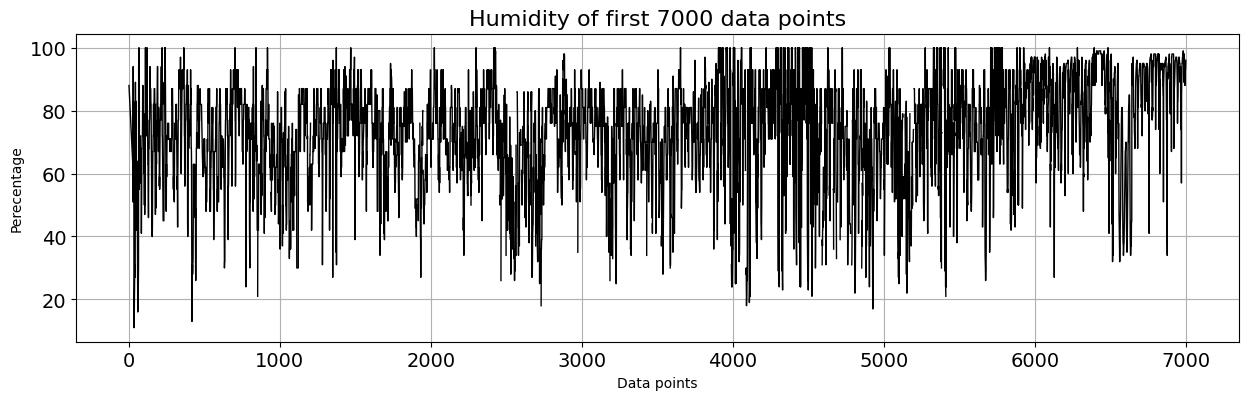

In [10]:
plt_train_points('humidity')

In [11]:
def plt_train_points(quantity='humidity',Tp=7000):
    plt.figure(figsize=(15,4))
    if quantity=='humidity':
        plt.title("Humidity of first {} data points".format(Tp),fontsize=16)
        plt.plot(humidity_SF['San Francisco'][:Tp],c='k',lw=1)
    if quantity=='temperature':
        plt.title("Temperature of first {} data points".format(Tp),fontsize=16)
        plt.plot(temp_SF['San Francisco'][:Tp],c='k',lw=1)
    if quantity=='pressure':
        plt.title("Pressure of first {} data points".format(Tp),fontsize=16)
        plt.plot(pressure_SF['San Francisco'][:Tp],c='k',lw=1)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.ylabel('Perecentage')
    plt.xlabel('Data points')
    plt.yticks(fontsize=14)
    plt.show()


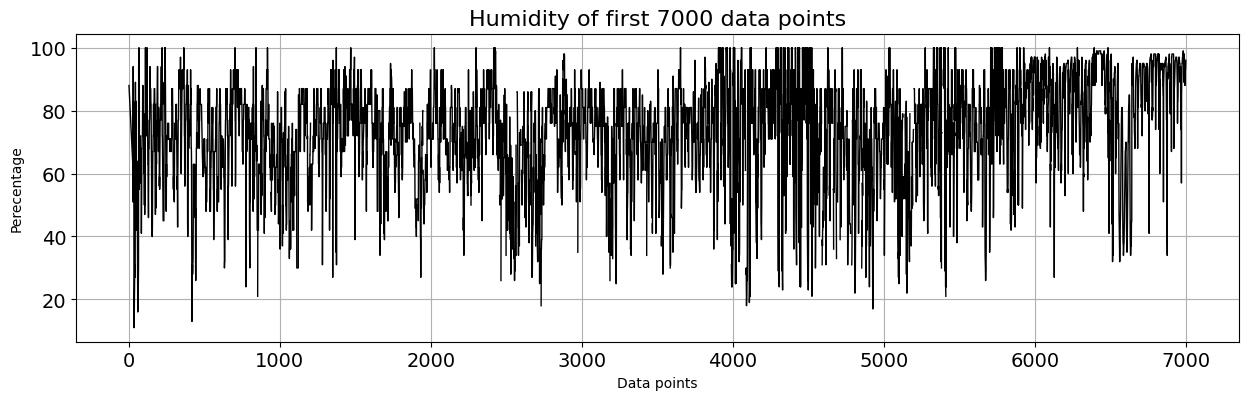

In [12]:
plt_train_points('humidity')

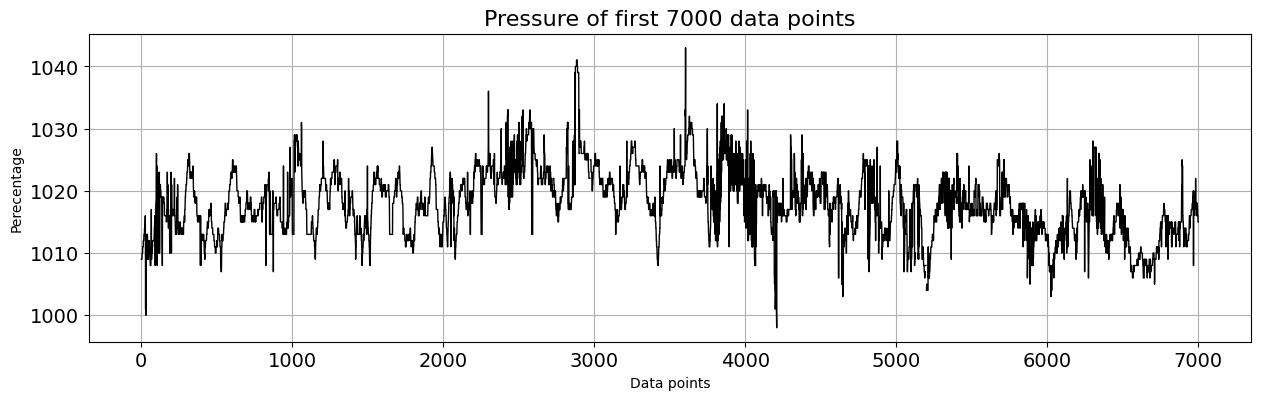

In [13]:
plt_train_points('pressure')

### Interpolate data points to fill up `NaN` values
We observed some `NaN` values in the dataset. We could just eliminate these points. But assuming that the changes in the parameters are not extremely abrupt, we could try to fill them using simple linear interpolation.

In [14]:
humidity_SF.interpolate(inplace=True)
humidity_SF.dropna(inplace=True)

temp_SF.interpolate(inplace=True)
temp_SF.dropna(inplace=True)

pressure_SF.interpolate(inplace=True)
pressure_SF.dropna(inplace=True)

/tmp/ipython-input-14-2399150452.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  humidity_SF.interpolate(inplace=True)
/tmp/ipython-input-14-2399150452.py:4: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  temp_SF.interpolate(inplace=True)
/tmp/ipython-input-14-2399150452.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  pressure_SF.interpolate(inplace=True)


In [15]:
print(humidity_SF.shape)
print(temp_SF.shape)
print(pressure_SF.shape)

(45252, 2)
(45252, 2)
(45252, 2)


### Train and test splits on the `Tp=7000`

In [16]:
train = np.array(humidity_SF['San Francisco'][:Tp])
test = np.array(humidity_SF['San Francisco'][Tp:])

In [17]:

print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (7000,)
Test data length: (38252,)


In [18]:
train=train.reshape(-1,1)
test=test.reshape(-1,1)

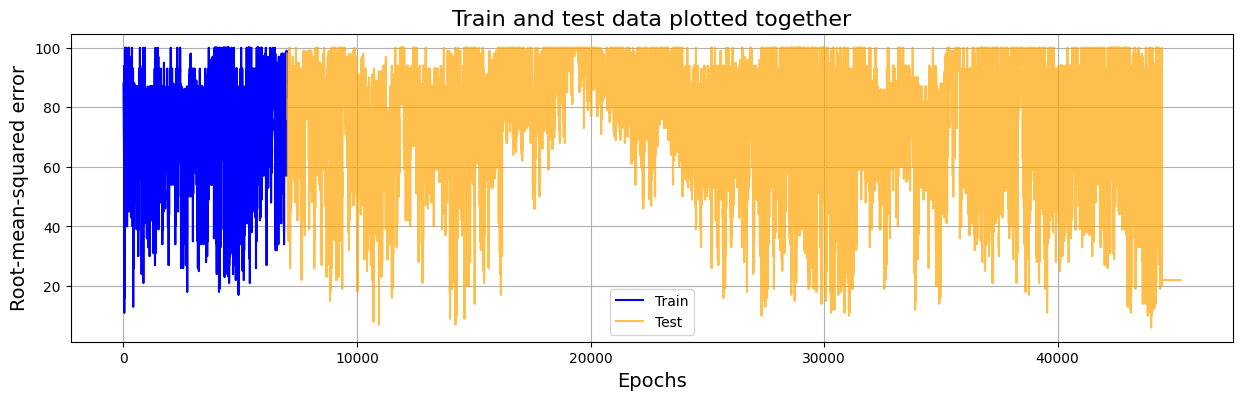

In [19]:
plt.figure(figsize=(15,4))
plt.title("Train and test data plotted together", fontsize=16)
plt.plot(np.arange(Tp), train, c='blue')
plt.plot(np.arange(Tp, Tp + len(test)), test, c='orange', alpha=0.7)
plt.legend(['Train','Test'])
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)

plt.show()


### Choose the embedding or step size
RNN model requires a step value that contains n number of elements as an input sequence.

Suppose x = {1,2,3,4,5,6,7,8,9,10}

for step=1, x input  and its y prediction become:

| x  | y  |
|---|---|
| 1  | 2  |
| 2  | 3  |
| 3  | 4  |
| ...  | ...  |
| 9  | 10  |

for step=3, x and y contain:

| x  | y  |
|---|---|
| 1,2,3  | 4  |
| 2,3,4  | 5  |
| 3,4,5  | 6  |
| ...  | ...  |
| 7,8,9  | 10  |

Here, we choose `step=8`. In more complex RNN and in particular for text processing, this is also called _embedding size_. The idea here is that **we are assuming that 8 hours of weather data can effectively predict the 9th hour data, and so on.**

In [20]:
step = 8

In [21]:
# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))

In [22]:
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (7008,)
Test data length: (38260,)


### Converting to a multi-dimensional array
Next, we'll convert test and train data into the matrix with step value as it has shown above example.

In [23]:
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

In [24]:
trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)

In [25]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [26]:
print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (7000, 1, 8) ,  (7000,)
Test data shape: (38252, 1, 8) ,  (38252,)


## Modeling

### Keras model with `SimpleRNN` layer

We build a simple function to define the RNN model. It uses a single neuron for the output layer because we are predicting a real-valued number here. As activation, it uses the ReLU function. Following arguments are supported.

- neurons in the RNN layer
- embedding length (i.e. the step length we chose)
- nenurons in the densely connected layer
- learning rate

In [27]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Input
from keras.optimizers import RMSprop

def build_simple_rnn(num_units=128, embedding=4, num_dense=32, lr=0.001):
    """
    Builds and compiles a simple RNN model.
    """
    model = Sequential()
    model.add(Input(shape=(1, embedding)))
    model.add(SimpleRNN(units=num_units, activation="relu"))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate=lr), metrics=['mse'])

    return model

In [28]:
model_humidity = build_simple_rnn(num_units=128, num_dense=32, embedding=8, lr=0.0005)

In [29]:
model_humidity.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        17,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,697 (84.75 KB)

 Trainable params: 21,697 (84.75 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % 50 == 0 and epoch>0:
            print("Epoch number {} done".format(epoch+1))

### Batch size and number of epochs

In [31]:
batch_size=8
num_epochs = 5

### Training the model

In [32]:
model_humidity.fit(trainX,trainY,
          epochs=num_epochs,
          batch_size=batch_size,
          callbacks=[MyCallback()],verbose=0)

### Plot RMSE loss over epochs
Note that the `loss` metric available in the `history` attribute of the model is the MSE loss and you have to take a square-root to compute the RMSE loss.

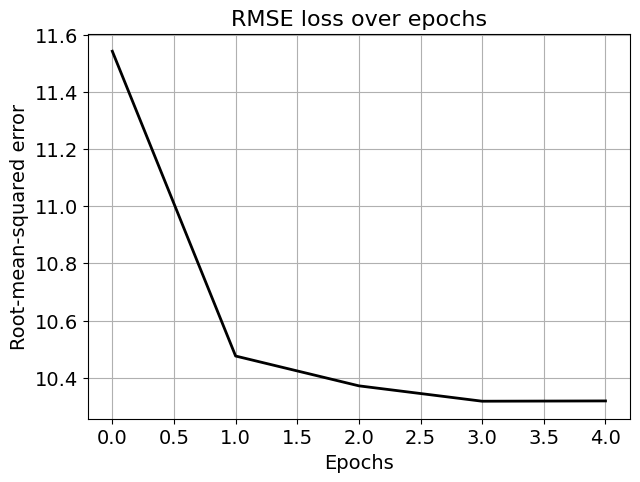

In [33]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model_humidity.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Result and analysis

### What did the model see while training?
We are emphasizing and showing again what exactly the model see during training. If you look above, the model fitting code is,

```
model_humidity.fit(trainX,trainY,
          epochs=num_epochs,
          batch_size=batch_size,
          callbacks=[MyCallback()],verbose=0)
```

So, the model was fitted with `trainX` which is plotted below, and `trainY` which is just the 8 step shifted and shaped vector.

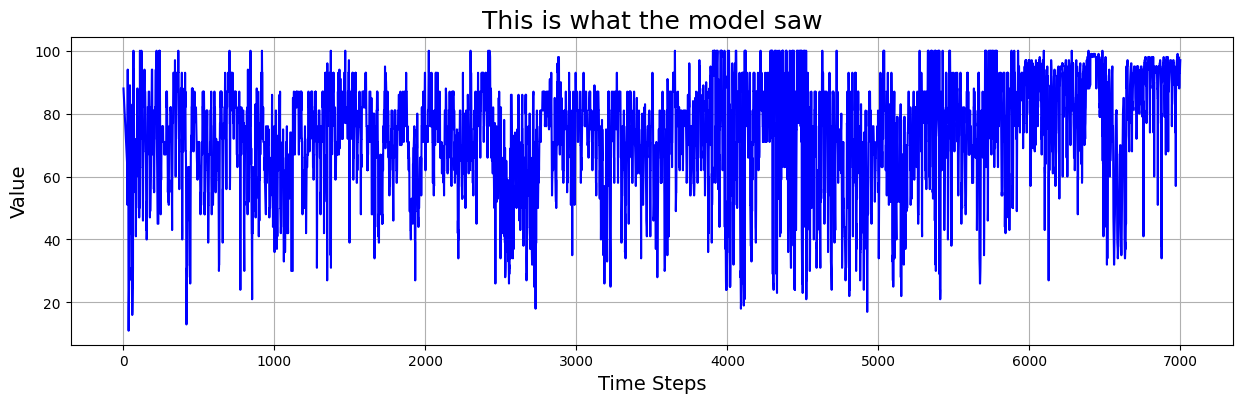

In [34]:
plt.figure(figsize=(15,4))
plt.title("This is what the model saw",fontsize=18)
plt.plot(trainX[:,0][:,0],c='blue')
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.grid(True)
plt.show()

### Now predict the future points
Now, we can generate predictions for the future by passing `testX` to the trained model.

In [35]:
trainPredict = model_humidity.predict(trainX)
testPredict= model_humidity.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


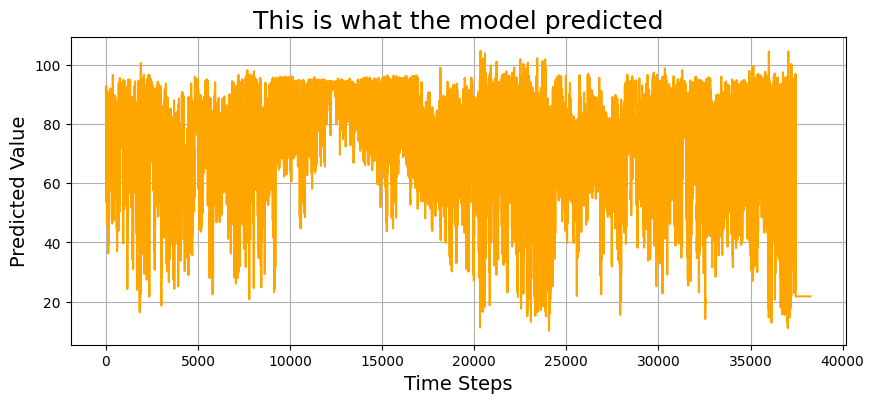

In [36]:
plt.figure(figsize=(10,4))
plt.title("This is what the model predicted",fontsize=18)
plt.plot(testPredict,c='orange')
plt.xlabel("Time Steps", fontsize=14)
plt.ylabel("Predicted Value", fontsize=14)
plt.grid(True)
plt.show()

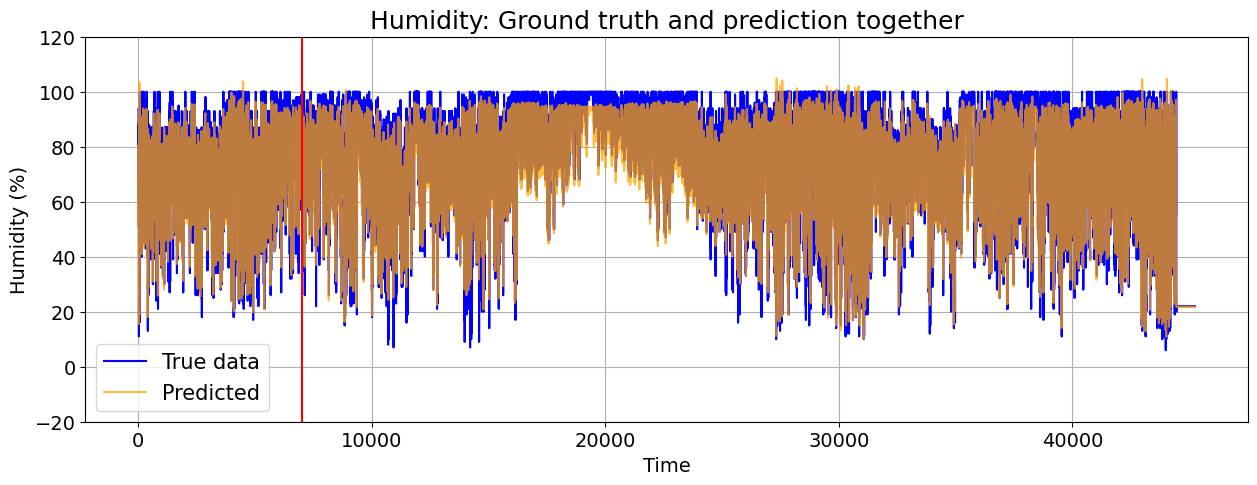

In [37]:
index = humidity_SF.index.values

plt.figure(figsize=(15, 5))
plt.title("Humidity: Ground truth and prediction together", fontsize=18)

plt.plot(index, humidity_SF['San Francisco'], c='blue')
plt.plot(index, predicted, c='orange', alpha=0.75)


plt.xlabel("Time", fontsize=14)
plt.ylabel("Humidity (%)", fontsize=14)

plt.legend(['True data', 'Predicted'], fontsize=15)
plt.axvline(x=Tp, c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(-20, 120)

plt.show()


In [38]:
train = np.array(temp_SF['San Francisco'][:Tp])
test = np.array(temp_SF['San Francisco'][Tp:])

train=train.reshape(-1,1)
test=test.reshape(-1,1)

step = 8

# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))

trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [39]:
model_temp = build_simple_rnn(num_units=128,num_dense=32,embedding=8,lr=0.0005)

batch_size=8
num_epochs = 10

model_temp.fit(trainX,trainY,
          epochs=num_epochs,
          batch_size=batch_size,
          callbacks=[MyCallback()],verbose=0)

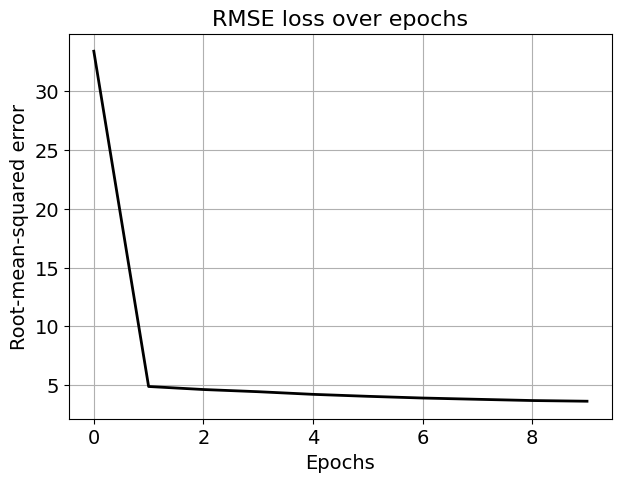

In [40]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model_temp.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [41]:
trainPredict = model_temp.predict(trainX)
testPredict= model_temp.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


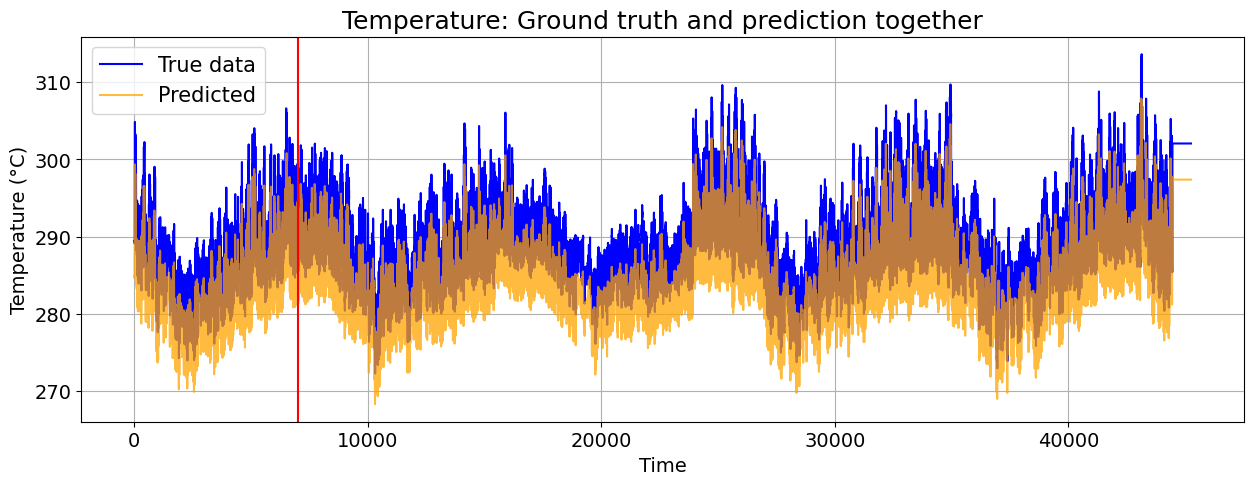

In [42]:
index = temp_SF.index.values

plt.figure(figsize=(15,5))
plt.title("Temperature: Ground truth and prediction together",fontsize=18)
plt.plot(index,temp_SF['San Francisco'],c='blue')
plt.plot(index,predicted,c='orange',alpha=0.75)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Temperature (°C)", fontsize=14)
plt.legend(['True data','Predicted'],fontsize=15)
plt.axvline(x=Tp, c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Modeling the atmospheric pressure data

In [43]:
train = np.array(pressure_SF['San Francisco'][:Tp])
test = np.array(pressure_SF['San Francisco'][Tp:])

train=train.reshape(-1,1)
test=test.reshape(-1,1)

step = 8

# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))

trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [44]:
model_pressure = build_simple_rnn(num_units=128,num_dense=32,embedding=8,lr=0.0005)

batch_size=8
num_epochs = 5

model_pressure.fit(trainX,trainY,
          epochs=num_epochs,
          batch_size=batch_size,
          callbacks=[MyCallback()],verbose=0)

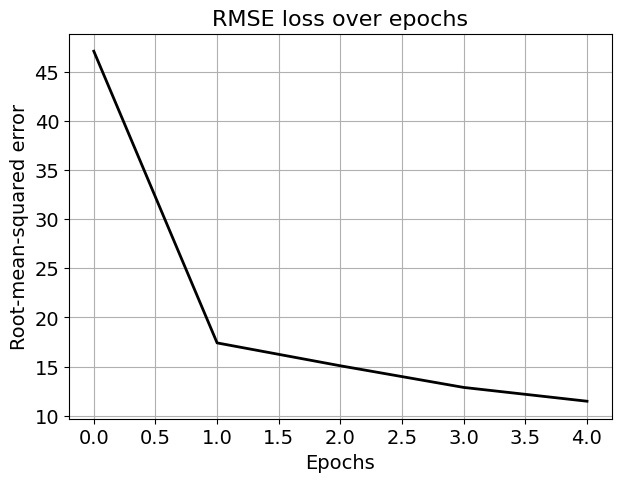

In [45]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(model_pressure.history.history['loss']),c='k',lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [46]:
trainPredict = model_pressure.predict(trainX)
testPredict= model_pressure.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


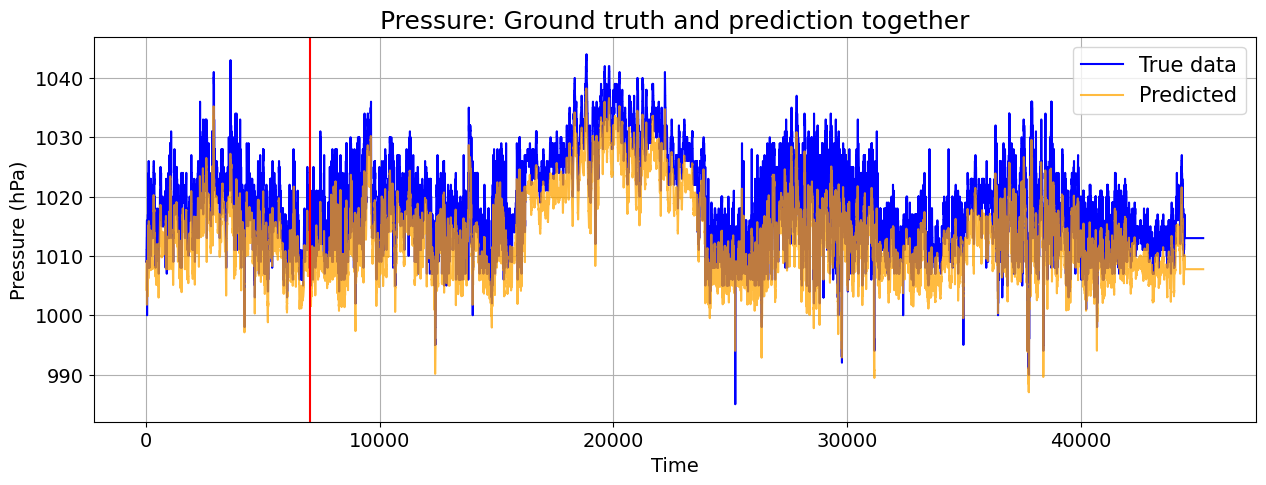

In [47]:
index = pressure_SF.index.values

plt.figure(figsize=(15,5))
plt.title("Pressure: Ground truth and prediction together",fontsize=18)
plt.plot(index,pressure_SF['San Francisco'],c='blue')
plt.plot(index,predicted,c='orange',alpha=0.75)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Pressure (hPa)", fontsize=14)
plt.legend(['True data','Predicted'],fontsize=15)
plt.axvline(x=Tp, c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [48]:

# Combine temperature, humidity, and pressure data on datetime
data_combined = pd.merge(temp_SF, humidity_SF, on='datetime', suffixes=('_temp', '_humidity'))
data_combined = pd.merge(data_combined, pressure_SF, on='datetime')
data_combined.columns = ['datetime', 'temp', 'humidity', 'pressure']
data_combined.dropna(inplace=True)


In [49]:

# Function to classify weather condition
def classify_weather(temp, humidity, pressure):
    if humidity > 80 and temp < 25:
        return 'Rainy'
    elif temp > 30 and humidity < 50:
        return 'Sunny'
    else:
        return 'Cloudy'

# Apply the classification to the dataset
data_combined['weather_label'] = data_combined.apply(lambda row: classify_weather(row['temp'], row['humidity'], row['pressure']), axis=1)


In [50]:

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Encode labels
label_encoder = LabelEncoder()
data_combined['label_encoded'] = label_encoder.fit_transform(data_combined['weather_label'])

# Features and labels
X = data_combined[['temp', 'humidity', 'pressure']].values
y = to_categorical(data_combined['label_encoded'].values)

# Reshape for RNN input: (samples, timesteps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [51]:

# Define and train RNN model
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

model_weather = Sequential()
model_weather.add(SimpleRNN(32, input_shape=(1, 3)))
model_weather.add(Dense(16, activation='relu'))
model_weather.add(Dense(y.shape[1], activation='softmax'))

model_weather.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_weather.fit(X_train, y_train, epochs=20, batch_size=8, validation_split=0.1)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4073/4073 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8933 - loss: 0.3302 - val_accuracy: 0.9136 - val_loss: 0.2943
Epoch 2/20
4073/4073 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9047 - loss: 0.3158 - val_accuracy: 0.9136 - val_loss: 0.2946
Epoch 3/20
4073/4073 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9026 - loss: 0.3206 - val_accuracy: 0.9136 - val_loss: 0.2942
Epoch 4/20
4073/4073 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9039 - loss: 0.3178 - val_accuracy: 0.9136 - val_loss: 0.2946
Epoch 5/20
4073/4073 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9055 - loss: 0.3140 - val_accuracy: 0.9136 - val_loss: 0.2950
Epoch 6/20
4073/4073 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9038 - loss: 0.3182 - val_accuracy: 0.9136 - val_loss: 0.2959
Epoch 7/20
4073/4073 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9029 - loss: 0.3194 - val_accuracy: 0.9136 - val_loss: 0.2975
Epoch 8/20
4073/4073 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9030 - loss: 0.3194 - val_

In [52]:

# Predict weather from new input
def predict_weather(temperature, humidity, pressure):
    input_data = np.array([[temperature, humidity, pressure]])
    input_data = input_data.reshape((1, 1, 3))
    prediction = model_weather.predict(input_data)
    predicted_class = np.argmax(prediction)
    label = label_encoder.inverse_transform([predicted_class])[0]
    print(f"Predicted weather: {label}")
    return label

# Example usage
predict_weather(temperature=32, humidity=40, pressure=1012)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Predicted weather: Cloudy


'Cloudy'